# Technical indicators

In [358]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from ta import momentum, trend, volume
from alpha_vantage.techindicators import TechIndicators
from dotenv import load_dotenv
from datetime import datetime, timedelta
from alpha_vantage import timeseries


load_dotenv()
stock = 'TSLA'

key = os.environ["ALPHA_VANTAGE_KEY"]


## Load data from file or create new file

In [297]:
try:
    df = pd.read_csv(f"{stock}.csv", index_col=0, parse_dates=[0])
    latest_timestamp = datetime.fromtimestamp(df.index[0].timestamp()).date()
    yesterday = datetime.now().date() - timedelta(days=1)
    if latest_timestamp != yesterday:
        raise Exception
except Exception:
    key = os.environ["ALPHA_VANTAGE_KEY"]
    ts = timeseries.TimeSeries(key=key, output_format="pandas")
    df, _ = ts.get_daily_adjusted(symbol=stock, outputsize="full")
    df.to_csv(f"{stock}.csv")

## SMA - Simple Moving Average

In [298]:
def get_sma(close, window=12, fillna=False):
    return trend.sma_indicator(close=close, window=window, fillna=fillna)

# Reverse the dataset to put in the oldest values first
sma = get_sma(df['5. adjusted close'][::-1])

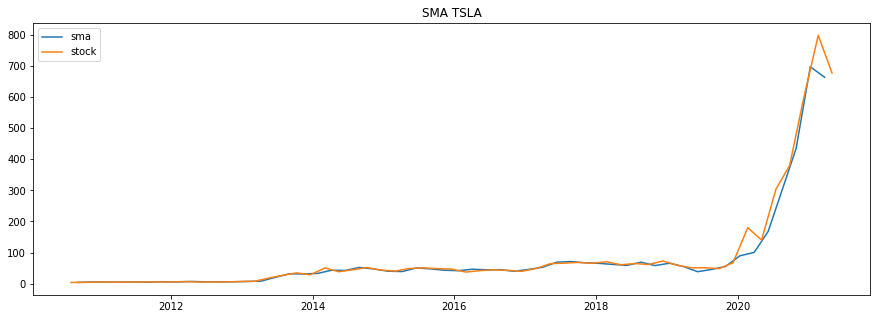

In [299]:
# Plot every 50th item

plt.figure(figsize=(15,5))
plt.plot(sma.keys()[::50], sma[::50], label="sma")
plt.plot(df.index[::50], df['5. adjusted close'][::50], label="stock")
plt.legend()
plt.title(f"SMA {stock}")
plt.show()

## EMA - Exponential Moving Average

In [300]:
def get_ema(close, window=12, fillna=False):
    return trend.ema_indicator(close=close, window=window, fillna=fillna)


# Reverse the dataset to put in the oldest values first
ema = get_ema(df['5. adjusted close'][::-1])

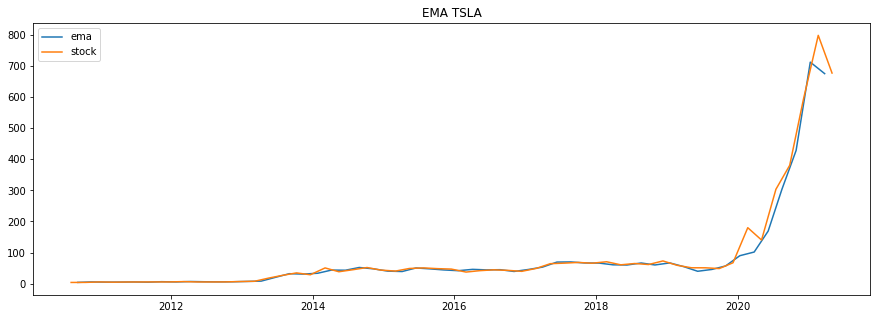

In [301]:
# Plot every 50th item
plt.figure(figsize=(15,5))
plt.plot(ema.keys()[::50], ema[::50], label='ema')
plt.plot(df.index[::50], df['5. adjusted close'][::50], label="stock")
plt.legend()
plt.title(f"EMA {stock}")
plt.show()

## ROC - Rate of Change

In [302]:
def get_roc(close, window=12, fillna=False):
    return momentum.roc(close, window=window, fillna=False)


roc = get_roc(df['5. adjusted close'][::-1])

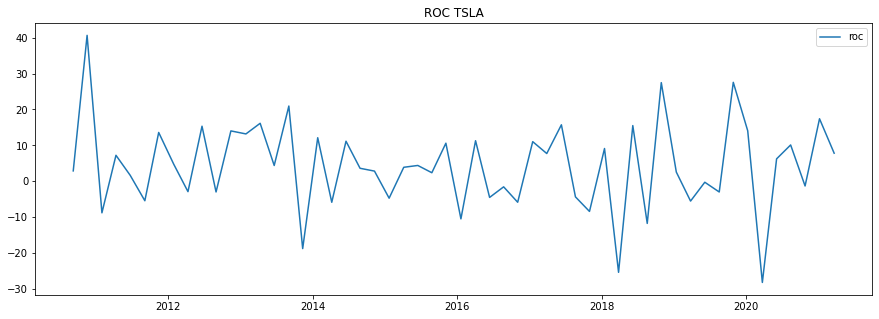

In [303]:
# Plot every 50th item
plt.figure(figsize=(15,5))
plt.plot(roc.keys()[::50], roc[::50], label='roc')
# plt.plot(df.index[::50], df['5. adjusted close'][::50], label="stock")
plt.legend()
plt.title(f"ROC {stock}")
plt.show()

## RSI - Relative Strength Indicator
> 70 = Overbought
< 30 = Oversold

In [345]:
def get_rsi(close, window=14, fillna=False):
    return momentum.rsi(close, window=window, fillna=False)

rsi = get_rsi(df['5. adjusted close'][::-1])

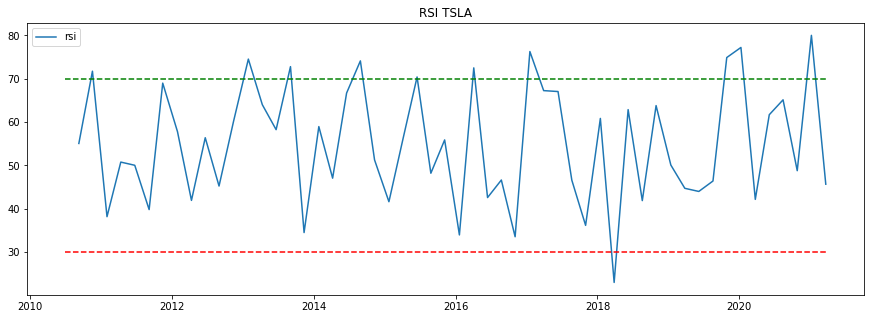

In [366]:
# Plot every 50th item
plt.figure(figsize=(15,5))
plt.plot(rsi.keys()[::50], rsi[::50], label='rsi')
plt.plot(rsi.keys()[::50], np.full((rsi.size),70)[::50], "g--")
plt.plot(rsi.keys()[::50], np.full((rsi.size),30)[::50], "r--")
# plt.plot(df.index[::50], df['5. adjusted close'][::50], label="stock")
plt.legend()
plt.title(f"RSI {stock}")
plt.show()

## OBV - On-Balance Volume

In [306]:
def get_obv(close, volume_input, fillna=False):
    return volume.on_balance_volume(close=close, volume=volume_input, fillna=False)

obv = get_obv(close=df['5. adjusted close'][::-1],volume_input=df['6. volume'][::-1])

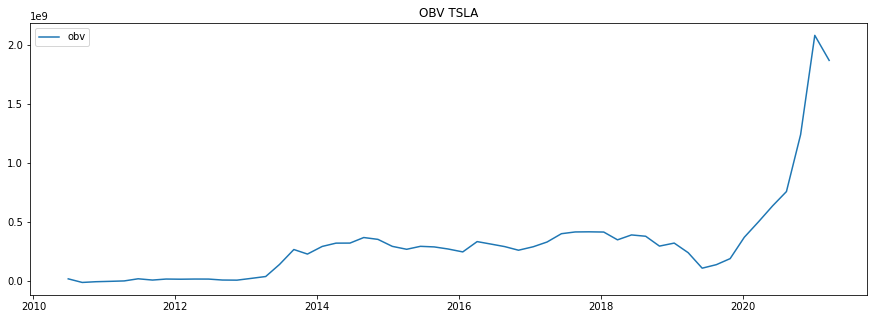

In [307]:
# Plot every 50th item
plt.figure(figsize=(15,5))
plt.plot(obv.keys()[::50], obv[::50], label='obv')
# plt.plot(df.index[::50], df['5. adjusted close'][::50], label="stock")
plt.legend()
plt.title(f"OBV {stock}")
plt.show()

## Define comparison methods

In [308]:
def prepare_indicator(local_indicator, name, decimals):
    if not isinstance(local_indicator, pd.DataFrame):
        local_indicator = local_indicator.to_frame()
    local_indicator.rename(columns={f"{local_indicator.columns[0]}": f"{name}"}, inplace=True)
    local_indicator = local_indicator.round(decimals=decimals)
    local_indicator = local_indicator.dropna()
    return local_indicator


def calc_difference(local_indicator, av_indicator):
    difference= local_indicator.compare(av_indicator)
    if difference.size > 0:
        columns = difference.columns
        overall_difference = sum(abs(difference[columns[0]] - difference[columns[1]]))
        print(f"Overall difference in Alphavantage vs. local calculation: {overall_difference}")
    else:
        print("The data sets are identical")

In [309]:
ti = TechIndicators(key=key, output_format="pandas")

## Compare calculated SMA to Alphavantage SMA

In [310]:
sma_av, _ = ti.get_sma(symbol=stock, interval="daily", time_period=12, series_type="close")

In [311]:
sma = prepare_indicator(local_indicator=sma, name=f"{sma_av.columns[0]}", decimals=4)
calc_difference(local_indicator=sma, av_indicator=sma_av)

Overall difference in Alphavantage vs. local calculation: 0.004299999999993531


## Compare calculated EMA to Alphavantage EMA

In [312]:
ema_av, _ = ti.get_ema(symbol=stock, interval="daily", time_period=12,series_type="close")

In [313]:
ema = prepare_indicator(local_indicator=ema, name=f"{ema_av.columns[0]}", decimals=4)
calc_difference(local_indicator=ema, av_indicator=ema_av)

Overall difference in Alphavantage vs. local calculation: 0.30699999999999905


## Compare calculated ROC to Alphavantage ROC

In [314]:
roc_av, _ = ti.get_roc(symbol=stock, interval="daily", time_period=12,series_type="close")

In [316]:
roc = prepare_indicator(local_indicator=roc, name=f"{roc_av.columns[0]}", decimals=4)
calc_difference(local_indicator=roc, av_indicator=roc_av)

The data sets are identical


## Compare calculated RSI to Alphavantage RSI

In [350]:
rsi_av, _ = ti.get_rsi(symbol=stock, interval="daily", time_period=14,series_type="close")

In [351]:
rsi_av.index

DatetimeIndex(['2010-07-20', '2010-07-21', '2010-07-22', '2010-07-23',
               '2010-07-26', '2010-07-27', '2010-07-28', '2010-07-29',
               '2010-07-30', '2010-08-02',
               ...
               '2021-04-16', '2021-04-19', '2021-04-20', '2021-04-21',
               '2021-04-22', '2021-04-23', '2021-04-26', '2021-04-27',
               '2021-04-28', '2021-04-29'],
              dtype='datetime64[ns]', name='date', length=2714, freq=None)

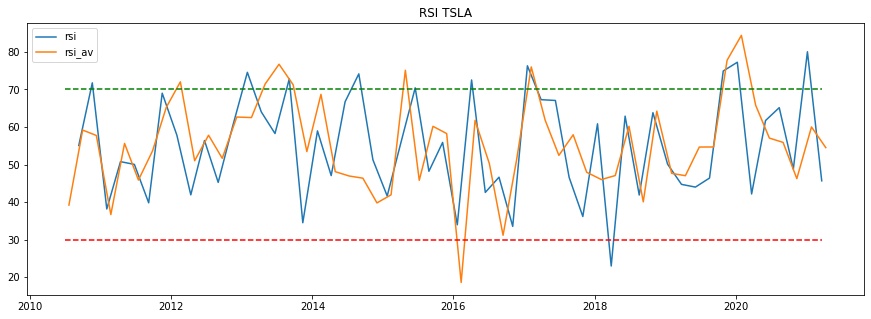

In [368]:
# Plot every 50th item
plt.figure(figsize=(15,5))
plt.plot(rsi.keys()[::50], rsi[::50], label='rsi')
plt.plot(rsi_av.index[::50], rsi_av[::50], label='rsi_av')
plt.plot(rsi.keys()[::50], np.full((rsi.size),70)[::50], "g--")
plt.plot(rsi.keys()[::50], np.full((rsi.size),30)[::50], "r--")
# plt.plot(df.index[::50], df['5. adjusted close'][::50], label="stock")
plt.legend()
plt.title(f"RSI {stock}")
plt.show()

In [328]:
rsi = prepare_indicator(local_indicator=rsi, name=f"{rsi_av.columns[0]}", decimals=4)
rsi
# calc_difference(local_indicator=rsi, av_indicator=rsi_av)

,RSI
date,
2010-07-19,55.1423
2010-07-20,46.5352
2010-07-21,46.1497
2010-07-22,50.4586
2010-07-23,51.9966
...,...
2021-04-23,54.8404
2021-04-26,56.3324
2021-04-27,49.6196
